In [84]:
import sys
sys.path.append("..")

import json

from pathlib import Path
from collections import defaultdict
# from src.graph.load_gfa import load_gfa
from src.graph.info_from_gfa import load_info_graph
from src.utils.params_from_path import params_from_path
from src.utils.info_from_exp import get_info_from_exp

import seaborn as sns
import seaborn.objects as so
import pandas as pd
import matplotlib.pyplot as plt
sns.set_theme(rc = {'figure.figsize':(10,8)})

In [85]:
NSEQS =50
NAME = f"{NSEQS}-SARS-CoV2-MSA"
PATH_SAVE = Path(f"../output-experiments-paper/sars-cov-2-{NSEQS}-row_maximal-vs-complete-not_alpha_consistent/")
PATH_SAVE.mkdir(exist_ok=True, parents=True)

PATH_EXPERIMENTS=Path("/data/analysis-paper/paper-experiment-decomposition")

#  this value of alpha (THRESHOLD_VERTICAL_BLOCKS in config.json) will be used.
ALPHA_BY_SEQS = {
    20: 659,
    50: 290,
}

In [86]:
OBJ_FUNCTIONS = ["blocks", "weighted", "depth", ]#"strings","pen_strings"]
ALPHAS = [ALPHA_BY_SEQS[NSEQS]]
MIN_LEN = [0, 20]
MIN_COVERAGE = [0.0, 0.3]
ALPHA_LABELS = [ f"{chr(945)}={alpha}" for alpha in ALPHAS]
DECOMPOSITIONS = ["row-maximal", "complete"]

### Other tools

#### `pggb` and `vg`

In [87]:
path_pggb = list(Path(f"../paper-graphs-tools/pggb/{NSEQS}-sars-cov-2-ena").rglob("*.gfa"))[0]
info_pggb = load_info_graph(path_pggb)
info_pggb

{'n_vertices': 807,
 'n_edges': 1066,
 'len_graph': 30358,
 'potential_seeds_len15': 26322,
 'potential_seeds_len20': 25266,
 'potential_seeds_len25': 24265,
 'nodes_depth_gt_011': 0.6815365551425031,
 'nodes_depth_gt_015': 0.677819083023544,
 'nodes_depth_gt_02': 0.6629491945477075,
 'nodes_depth_gt_025': 0.6579925650557621,
 'nodes_depth_gt_03': 0.654275092936803}

In [88]:
path_vg = Path(f"../paper-graphs-tools/vg/{NSEQS}-sars-cov-2-ena.gfa")
info_vg =  load_info_graph(path_vg) 
info_vg

{'n_vertices': 790,
 'n_edges': 1049,
 'len_graph': 30140,
 'potential_seeds_len15': 26179,
 'potential_seeds_len20': 25138,
 'potential_seeds_len25': 24151,
 'nodes_depth_gt_011': 0.7025316455696202,
 'nodes_depth_gt_015': 0.6987341772151898,
 'nodes_depth_gt_02': 0.6835443037974683,
 'nodes_depth_gt_025': 0.6784810126582278,
 'nodes_depth_gt_03': 0.6746835443037975}

## `row-maximal` vs `complete` decompositions

In [89]:
# path to folders with each decomposition
NAME=f"{NSEQS}-sars-cov-2-ena"
path_complete = PATH_EXPERIMENTS.joinpath(f"sars-cov-2-{NSEQS}-complete")
path_rowmaximal= PATH_EXPERIMENTS.joinpath(f"sars-cov-2-{NSEQS}-row_maximal")

In [90]:
df_graphs = pd.concat([
    get_info_from_exp(path_complete, name=NAME), 
    get_info_from_exp(path_rowmaximal, name=NAME)
    ], ignore_index=True)

df_graphs["objective_function"] = df_graphs["objective_function"].apply(lambda x: "blocks" if x=="nodes" else x)
df_graphs["objective_function"] = df_graphs["objective_function"].apply(lambda x: "pen_strings" if x=="depth_and_len" else x)

In [91]:
df_graphs.alpha.describe()

count    189.000000
mean     257.248677
std      175.102239
min        1.000000
25%       90.000000
50%      202.000000
75%      435.000000
max      610.000000
Name: alpha, dtype: float64

In [92]:
df_graphs.alpha.unique()

array([ 61, 128, 158, 439, 290, 488, 408, 249, 172,  90, 610,  60, 435,
        84, 500, 171, 366,   1, 202])

In [93]:
# data frame to plot
df_graphs_plot = df_graphs.query(
    f"""(objective_function=='blocks') or (objective_function=='weighted' and min_len==20) or (objective_function=='depth' and min_coverage==0.11)"""
    ).copy()
df_graphs_plot["alpha_label"] = df_graphs_plot["alpha"].apply(lambda x: f"{chr(945)}={x}")

ALPHA = ALPHA_BY_SEQS[NSEQS]
df_graphs_plot=df_graphs_plot.query(f"alpha=={ALPHA}").copy()#.head()

In [94]:
MARKERS=["o","s"] # o: circle , s: square
COLORS=["b","r"] # b: blue , r: red

LEGEND = True
## Fontsizes plots
FONTSIZE_TITLE = 18
FONTSIZE_SUBTITLE = 16
FONTSIZE_X = 16
FONTSIZE_Y = 16
FONTSIZE_TOOLS = 14 

FONTSIZE_GRID_TITLE = 18
FONTSIZE_GRID_SUBTITLE = 16
FONTSIZE_GRID_X = 16
FONTSIZE_GRID_Y = 16
FONTSIZE_GRID_TOOLS = 14 


### Number of vertices

In [95]:
feature = "n_vertices"

# min and max y-axis values
feat_min = min(df_graphs_plot[feature].min(), info_pggb[feature], info_vg[feature])
feat_max = max(df_graphs_plot[feature].max(), info_pggb[feature], info_vg[feature])
delta_range = feat_max - feat_min
ymin = feat_min - 0.1*delta_range 
ymax = feat_max + 0.1*delta_range

ymin, ymax


(394.9, 1116.1)

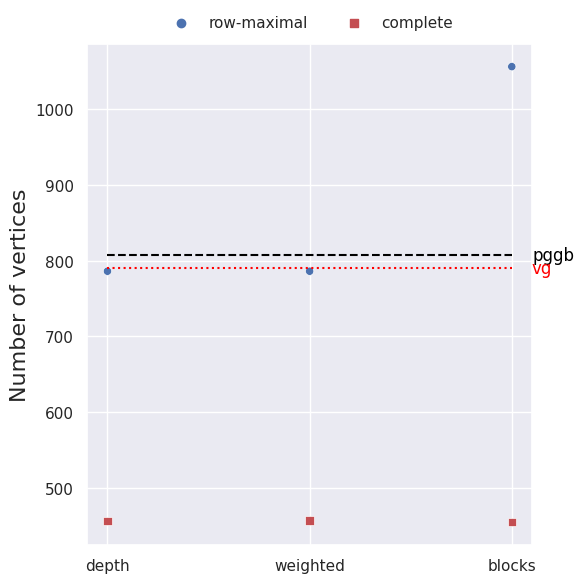

In [96]:
sns.set_theme(rc = {'figure.figsize':(6,6)})

g_nodes=sns.scatterplot(
    data=df_graphs_plot,
    x="objective_function", y=feature, 
    # col="alpha", 
    style="decomposition",
    # aspect=.8,
    style_order=DECOMPOSITIONS,
    markers=MARKERS,
    hue="decomposition",
    hue_order=DECOMPOSITIONS,
    palette=COLORS,
)

plt.hlines(y=info_pggb[feature], xmin=0, xmax=2.0, color="black", linestyles="dashed")
plt.text(2.1, info_pggb[feature], "pggb", ha='left', va='center', color="black")

plt.hlines(y=info_vg[feature], xmin=0, xmax=2.0, color="red", linestyles="dotted")
plt.text(2.1, info_vg[feature], "vg", ha='left', va='center', color="red")

g_nodes.set_xlabel(f"", fontdict=dict(fontsize=FONTSIZE_GRID_X))
g_nodes.set_ylabel("Number of vertices", fontdict=dict(fontsize=FONTSIZE_GRID_X))
# ax.set_title(f"{alpha_label}", fontsize=FONTSIZE_GRID_SUBTITLE)
g_nodes.set_title("")        

sns.move_legend(
    g_nodes, "lower center",
    bbox_to_anchor=(.5, 1), ncol=5, title="", frameon=False,
)

plt.tight_layout()

plt.savefig(PATH_SAVE.joinpath(f"{NAME}-{feature}.png"),dpi=300)

### Length of the graph

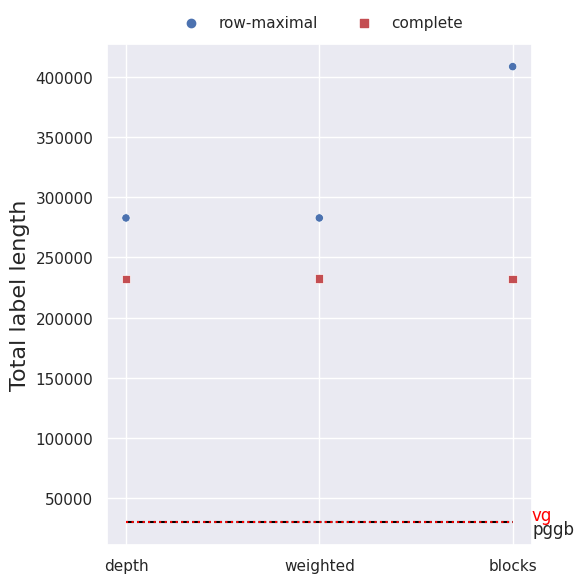

In [97]:
feature = "len_graph"
sns.set_theme(rc = {'figure.figsize':(6,6)})

g_len_graph=sns.scatterplot(
    data=df_graphs_plot,
    x="objective_function", y=feature, 
    # col="alpha", 
    style="decomposition",
    # aspect=.8,
    style_order=DECOMPOSITIONS,
    markers=MARKERS,
    hue="decomposition",
    hue_order=DECOMPOSITIONS,
    palette=COLORS,
)

plt.hlines(y=info_pggb[feature], xmin=0, xmax=2.0, color="black", linestyles="dashed")
plt.text(2.1, info_pggb[feature]*0.8, "pggb", ha='left', va='center')

plt.hlines(y=info_vg[feature], xmin=0, xmax=2.0, color="red", linestyles="dotted")
plt.text(2.1, info_vg[feature]*1.2, "vg", ha='left', va='center', color="red")

g_len_graph.set_xlabel(f"", fontdict=dict(fontsize=FONTSIZE_GRID_X))
g_len_graph.set_ylabel("Total label length", fontdict=dict(fontsize=FONTSIZE_GRID_X))
# ax.set_title(f"{alpha_label}", fontsize=FONTSIZE_GRID_SUBTITLE)
g_len_graph.set_title("")        

sns.move_legend(
    g_len_graph, "lower center",
    bbox_to_anchor=(.5, 1), ncol=5, title="", frameon=False,
)

plt.tight_layout()

plt.savefig(PATH_SAVE.joinpath(f"{NAME}-{feature}.png"),dpi=300)

### Seeds

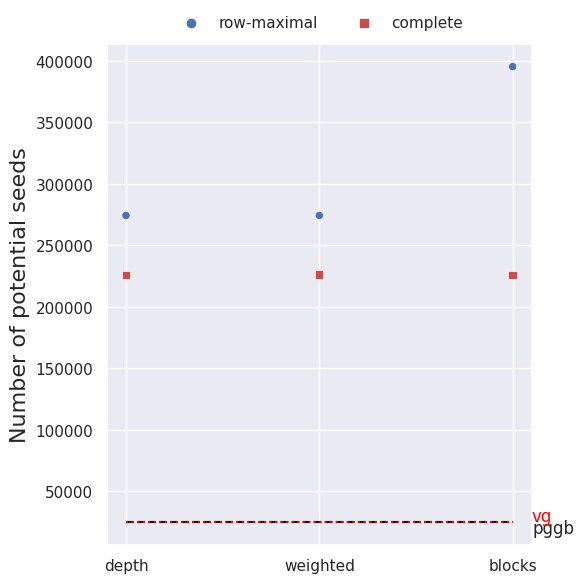

In [98]:
feature = "potential_seeds_len20"
sns.set_theme(rc = {'figure.figsize':(6,6)})

g_seeds=sns.scatterplot(
    data=df_graphs_plot,
    x="objective_function", y=feature, 
    # col="alpha", 
    style="decomposition",
    # aspect=.8,
    style_order=DECOMPOSITIONS,
    markers=MARKERS,
    hue="decomposition",
    hue_order=DECOMPOSITIONS,
    palette=COLORS,
)

plt.hlines(y=info_pggb[feature], xmin=0, xmax=2.0, color="black", linestyles="dashed")
plt.text(2.1, info_pggb[feature]*0.8, "pggb", ha='left', va='center')

plt.hlines(y=info_vg[feature], xmin=0, xmax=2.0, color="red", linestyles="dotted")
plt.text(2.1, info_vg[feature]*1.2, "vg", ha='left', va='center', color="red")

g_seeds.set_xlabel(f"", fontdict=dict(fontsize=FONTSIZE_GRID_X))
g_seeds.set_ylabel("Number of potential seeds", fontdict=dict(fontsize=FONTSIZE_GRID_X))
# ax.set_title(f"{alpha_label}", fontsize=FONTSIZE_GRID_SUBTITLE)
g_seeds.set_title("")        

sns.move_legend(
    g_seeds, "lower center",
    bbox_to_anchor=(.5, 1), ncol=5, title="", frameon=False,
)

plt.tight_layout()

plt.savefig(PATH_SAVE.joinpath(f"{NAME}-{feature}.png"),dpi=300)

### Node Coverage

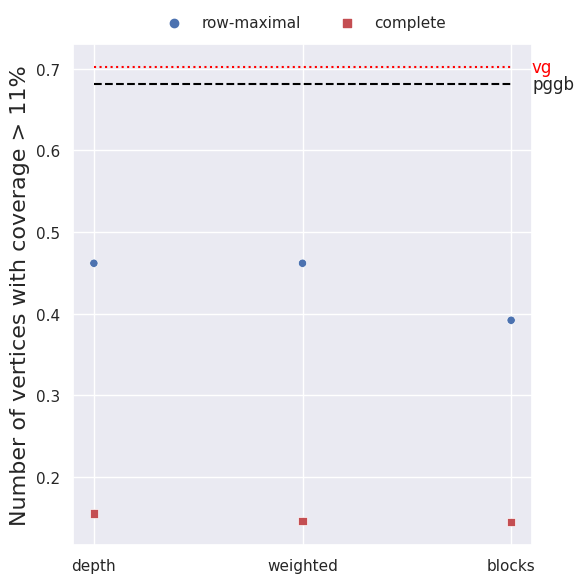

In [99]:
feature="nodes_depth_gt_011"
sns.set_theme(rc = {'figure.figsize':(6,6)})

g_depth=sns.scatterplot(
    data=df_graphs_plot,
    x="objective_function", y=feature, 
    # col="alpha", 
    style="decomposition",
    # aspect=.8,
    style_order=DECOMPOSITIONS,
    markers=MARKERS,
    hue="decomposition",
    hue_order=DECOMPOSITIONS,
    palette=COLORS,
)

plt.hlines(y=info_pggb[feature], xmin=0, xmax=2.0, color="black", linestyles="dashed")
plt.text(2.1, info_pggb[feature], "pggb", ha='left', va='center')

plt.hlines(y=info_vg[feature], xmin=0, xmax=2.0, color="red", linestyles="dotted")
plt.text(2.1, info_vg[feature], "vg", ha='left', va='center', color="red")

g_depth.set_xlabel(f"", fontdict=dict(fontsize=FONTSIZE_GRID_X))
g_depth.set_ylabel("Number of vertices with coverage > 11%", fontdict=dict(fontsize=FONTSIZE_GRID_X))
# ax.set_title(f"{alpha_label}", fontsize=FONTSIZE_GRID_SUBTITLE)
g_depth.set_title("")        

sns.move_legend(
    g_depth, "lower center",
    bbox_to_anchor=(.5, 1), ncol=5, title="", frameon=False,
)

plt.tight_layout()

plt.savefig(PATH_SAVE.joinpath(f"{NAME}-{feature}.png"),dpi=300)